In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
tf.keras.preprocessing.image_dataset_from_directory

<function keras.src.utils.image_dataset_utils.image_dataset_from_directory(directory, labels='inferred', label_mode='int', class_names=None, color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=None, validation_split=None, subset=None, interpolation='bilinear', follow_links=False, crop_to_aspect_ratio=False, pad_to_aspect_ratio=False, data_format=None, verbose=True)>

In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(dataset)

68

In [11]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 0 0 0 1 2 2 1 0 0 1 0 0 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0]


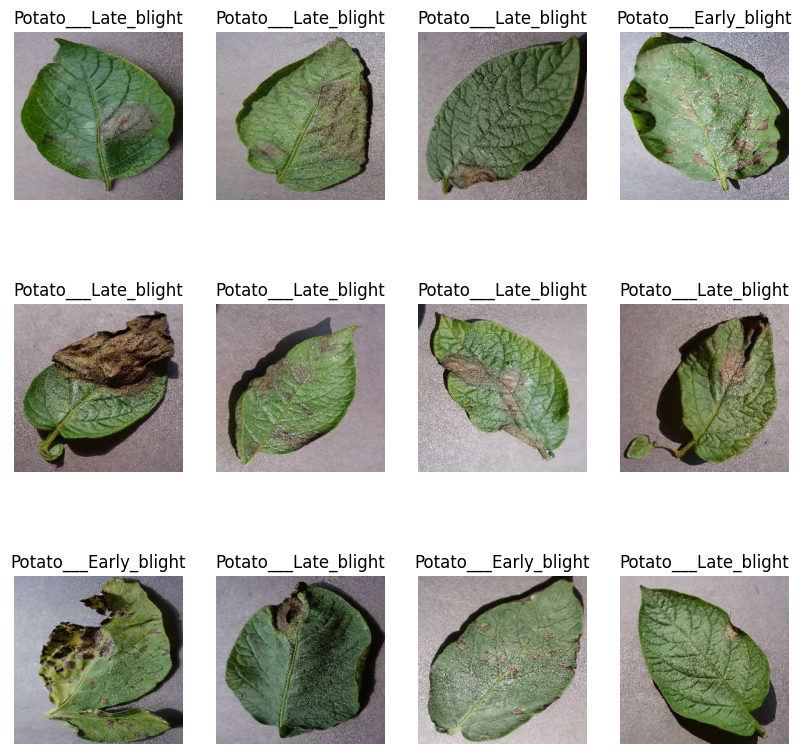

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
len(dataset)

68

In [14]:
train_ds = dataset.take(54)
len(train_ds)

54

In [15]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [19]:
len(val_ds)

6

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255),
])


In [24]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])


In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\mmahm\anaconda3\envs\tfenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 444ms/step - accuracy: 0.4959 - loss: 0.9402 - val_accuracy: 0.4479 - val_loss: 0.9237
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 427ms/step - accuracy: 0.5323 - loss: 0.8610 - val_accuracy: 0.6823 - val_loss: 0.7097
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 428ms/step - accuracy: 0.7251 - loss: 0.6317 - val_accuracy: 0.7344 - val_loss: 0.5857
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 446ms/step - accuracy: 0.8068 - loss: 0.4382 - val_accuracy: 0.9375 - val_loss: 0.1777
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 437ms/step - accuracy: 0.8399 - loss: 0.3995 - val_accuracy: 0.9323 - val_loss: 0.1483
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 446ms/step - accuracy: 0.9371 - loss: 0.1694 - val_accuracy: 0.9688 - val_loss: 0.1199
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 441ms/step - accuracy: 0.9388 - loss: 0.1567 - val_accuracy: 0.9167 - val_loss: 0.1803
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 447ms/step - accuracy: 0.9347 - loss: 0.1777 - val_accu

In [29]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.9936 - loss: 0.0126


In [30]:
scores

[0.007736890111118555, 0.99609375]

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

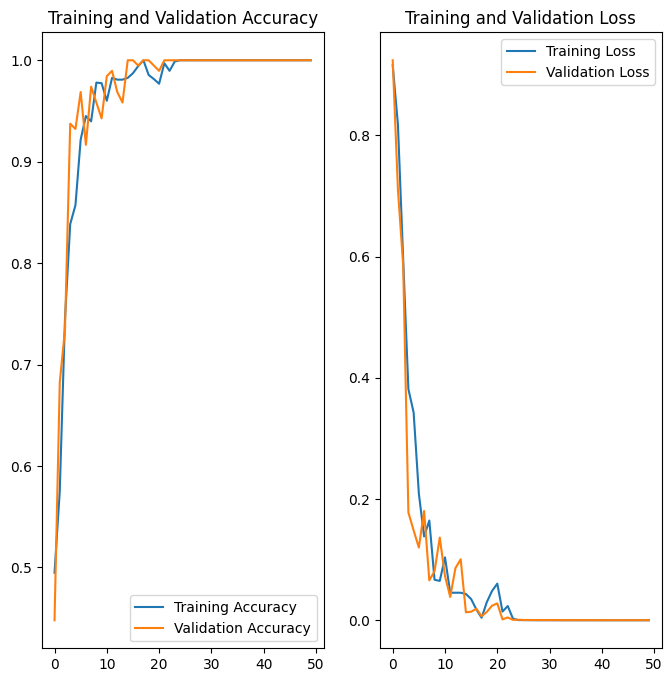

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
predicted label: Potato___Late_blight


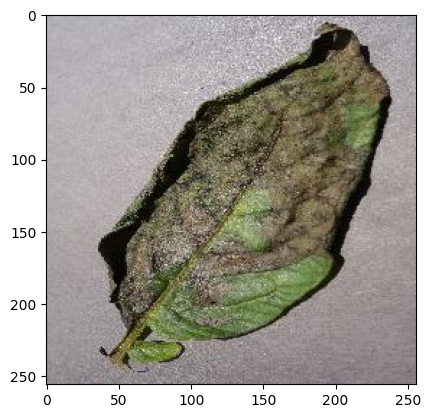

In [36]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


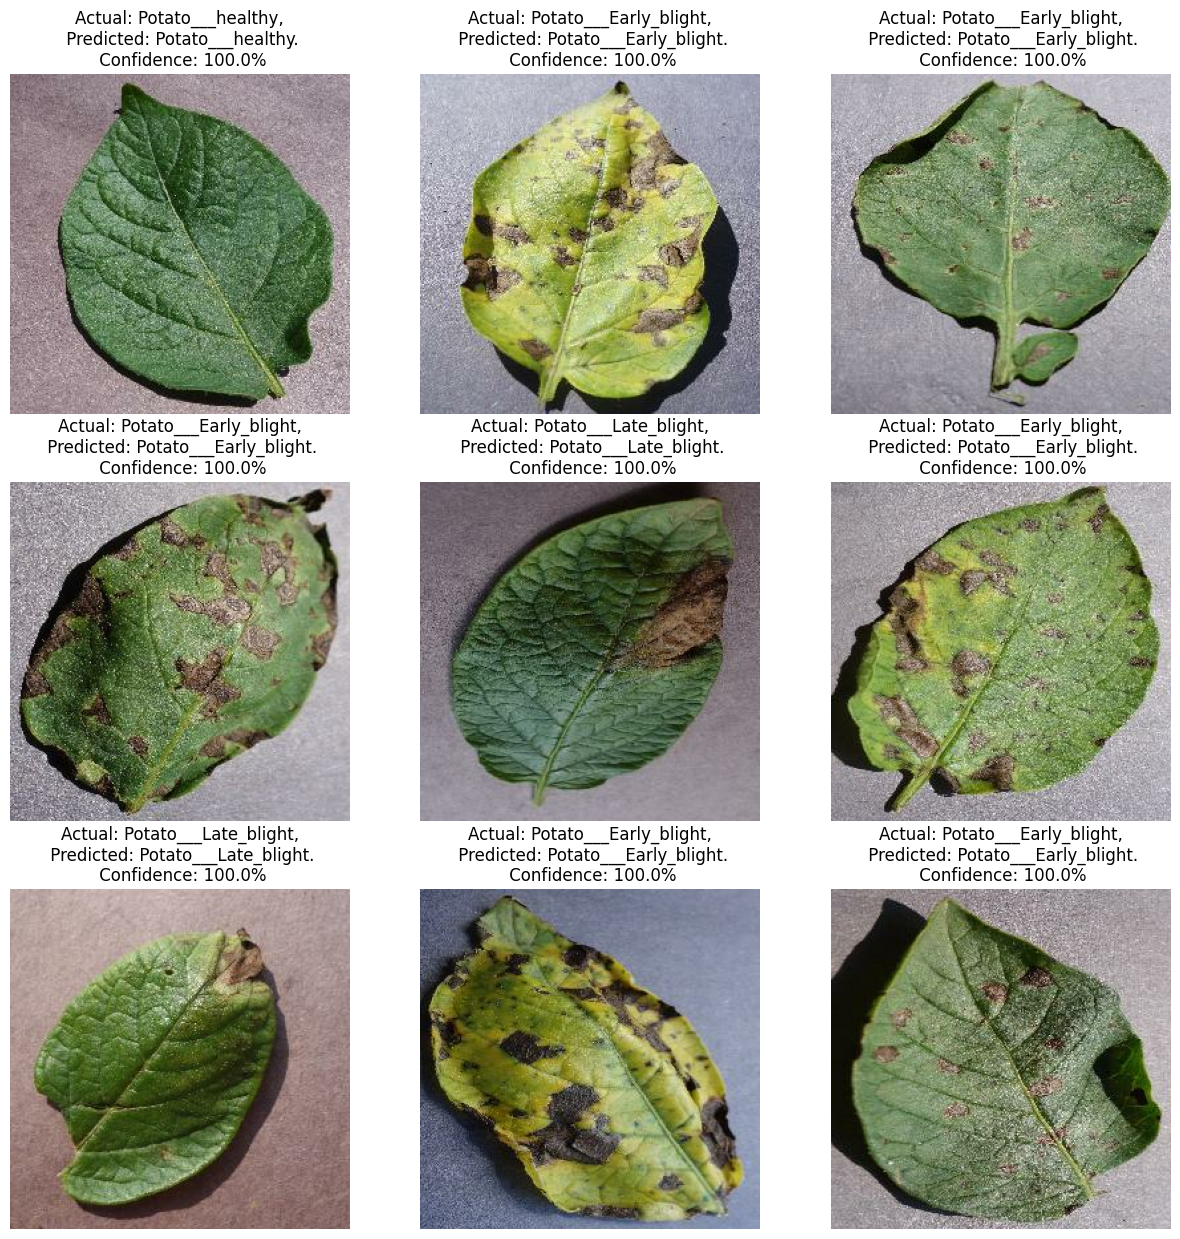

In [38]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [40]:
import os
model_version = max([int(i) for i in os.listdir("../models")] + [0]) + 1
model.save(f"../models/{model_version}.keras")